<a href="https://colab.research.google.com/github/hiiiiiiiiiieve/Anomaly-Detection/blob/main/LSTM-AE%2Cactivation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## *다변량 변수로 바꾸기*

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd

df1 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2011.csv")
df2 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2012.csv")
df3 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2013.csv")
df4 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2014.csv")
df5 = pd.read_csv("/content/drive/MyDrive/study/Private/1. 시계열 데이터 예측/1. dataset/gt_2015.csv")
gt_at = pd.concat([df1, df2, df3, df4, df5], ignore_index=True)
gt_at = gt_at[['AT']]

# LSTM-Autoencoder activation
## relu

Epoch 1/50
1148/1148 [==============================] - 40s 29ms/step - loss: 0.0305
Epoch 2/50
1148/1148 [==============================] - 34s 30ms/step - loss: 0.0034
Epoch 3/50
1148/1148 [==============================] - 33s 29ms/step - loss: 0.0029
Epoch 4/50
1148/1148 [==============================] - 32s 28ms/step - loss: 0.0025
Epoch 5/50
1148/1148 [==============================] - 34s 30ms/step - loss: 0.0018
Epoch 6/50
1148/1148 [==============================] - 34s 30ms/step - loss: 0.0015
Epoch 7/50
1148/1148 [==============================] - 33s 28ms/step - loss: 0.0014
Epoch 8/50
1148/1148 [==============================] - 35s 30ms/step - loss: 0.0014
Epoch 9/50
1148/1148 [==============================] - 33s 28ms/step - loss: 0.0012
Epoch 10/50
1148/1148 [==============================] - 32s 28ms/step - loss: 8.9921e-04
Epoch 11/50
1148/1148 [==============================] - 33s 29ms/step - loss: 7.9065e-04
Epoch 12/50
1148/1148 [==============================] 

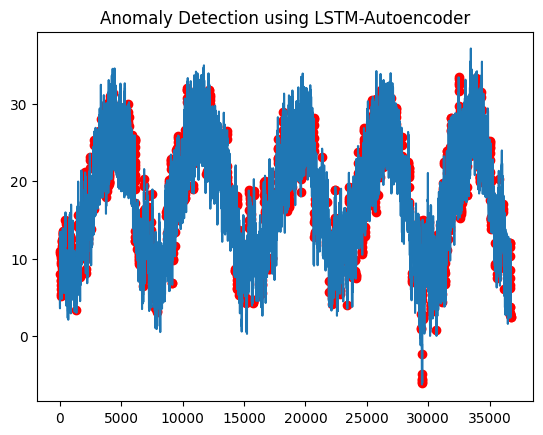

Number of anomalies: 1837


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.cluster import KMeans
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed

# LSTM-Autoencoder 모델 정의
scaler = StandardScaler()
gt_at['AT_scaled'] = scaler.fit_transform(gt_at[['AT']])
timesteps = 10  # 시퀀스 길이
input_dim = 1   # 특성 수 (AT만 사용)

def create_lstm_autoencoder(timesteps, input_dim):
    inputs = Input(shape=(timesteps, input_dim))
    # 인코더
    encoded = LSTM(128, activation='relu', return_sequences=False)(inputs)
    encoded = RepeatVector(timesteps)(encoded)
    # 디코더
    decoded = LSTM(128, activation='relu', return_sequences=True)(encoded)
    decoded = TimeDistributed(Dense(input_dim))(decoded)
    autoencoder = Model(inputs, decoded)
    return autoencoder

autoencoder = create_lstm_autoencoder(timesteps, input_dim)
autoencoder.compile(optimizer='adam', loss='mse')

# 시퀀스 데이터 생성
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:i + timesteps]
        sequences.append(seq)
    return np.array(sequences)

sequences = create_sequences(gt_at['AT_scaled'].values.reshape(-1, 1), timesteps)
autoencoder.fit(sequences, sequences, epochs=50, batch_size=32, shuffle=True)

# 재구성 오차 계산
reconstructed_sequences = autoencoder.predict(sequences)
mse = np.mean(np.power(sequences - reconstructed_sequences, 2), axis=1)

# 이상 탐지 결과 시각화
## 임계값은 보통 아래와 같이 결정됨
threshold = np.percentile(mse, 95)  # 95% 퍼센타일을 이상 탐지 임계값으로 설정
anomalies = mse > threshold

plt.plot(gt_at['AT'].values)
plt.scatter(np.where(anomalies)[0], gt_at['AT'].values[np.where(anomalies)[0]], color='r')  # 수정된 부분
plt.title('Anomaly Detection using LSTM-Autoencoder')
plt.show()

# 이상치 개수 계산 및 출력
num_anomalies = np.sum(anomalies)
print(f"Number of anomalies: {num_anomalies}")

Epoch 1/50
1148/1148 [==============================] - 36s 29ms/step - loss: 0.0257
Epoch 2/50
1148/1148 [==============================] - 32s 28ms/step - loss: 0.0032
Epoch 3/50
1148/1148 [==============================] - 32s 28ms/step - loss: 0.0028
Epoch 4/50
1148/1148 [==============================] - 38s 33ms/step - loss: 0.0028
Epoch 5/50
1148/1148 [==============================] - 33s 29ms/step - loss: 0.0021
Epoch 6/50
1148/1148 [==============================] - 34s 30ms/step - loss: 0.0016
Epoch 7/50
1148/1148 [==============================] - 32s 28ms/step - loss: 0.0014
Epoch 8/50
1148/1148 [==============================] - 32s 28ms/step - loss: 0.0014
Epoch 9/50
1148/1148 [==============================] - 32s 28ms/step - loss: 0.0013
Epoch 10/50
1148/1148 [==============================] - 35s 31ms/step - loss: 0.0010
Epoch 11/50
1148/1148 [==============================] - 32s 28ms/step - loss: 8.6548e-04
Epoch 12/50
1148/1148 [==============================] - 32

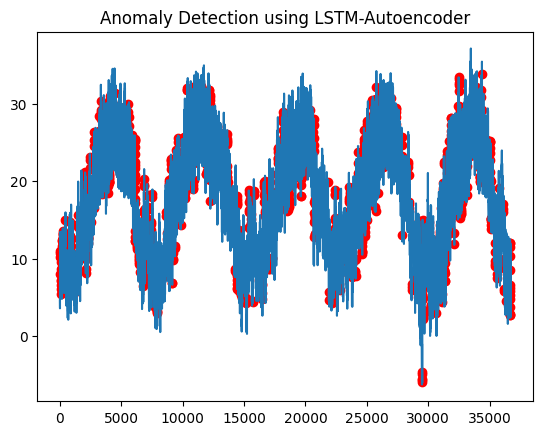

Number of anomalies: 1837


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from sklearn.cluster import KMeans
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed
from keras.layers import LeakyReLU

# LSTM-Autoencoder 모델 정의
scaler = StandardScaler()
gt_at['AT_scaled'] = scaler.fit_transform(gt_at[['AT']])
timesteps = 10  # 시퀀스 길이
input_dim = 1   # 특성 수 (AT만 사용)

def create_lstm_autoencoder(timesteps, input_dim):
    inputs = Input(shape=(timesteps, input_dim))
    # 인코더
    encoded = LSTM(128, activation=LeakyReLU(alpha=0.01), return_sequences=False)(inputs)
    encoded = RepeatVector(timesteps)(encoded)
    # 디코더
    decoded = LSTM(128, activation=LeakyReLU(alpha=0.01), return_sequences=True)(encoded)
    decoded = TimeDistributed(Dense(input_dim))(decoded)
    autoencoder = Model(inputs, decoded)
    return autoencoder

autoencoder = create_lstm_autoencoder(timesteps, input_dim)
autoencoder.compile(optimizer='adam', loss='mse')

# 시퀀스 데이터 생성
def create_sequences(data, timesteps):
    sequences = []
    for i in range(len(data) - timesteps):
        seq = data[i:i + timesteps]
        sequences.append(seq)
    return np.array(sequences)

sequences = create_sequences(gt_at['AT_scaled'].values.reshape(-1, 1), timesteps)
autoencoder.fit(sequences, sequences, epochs=50, batch_size=32, shuffle=True)

# 재구성 오차 계산
reconstructed_sequences = autoencoder.predict(sequences)
mse = np.mean(np.power(sequences - reconstructed_sequences, 2), axis=1)

# 이상 탐지 결과 시각화
## 임계값은 보통 아래와 같이 결정됨
threshold = np.percentile(mse, 95)  # 95% 퍼센타일을 이상 탐지 임계값으로 설정
anomalies = mse > threshold

plt.plot(gt_at['AT'].values)
plt.scatter(np.where(anomalies)[0], gt_at['AT'].values[np.where(anomalies)[0]], color='r')  # 수정된 부분
plt.title('Anomaly Detection using LSTM-Autoencoder')
plt.show()

# 이상치 개수 계산 및 출력
num_anomalies = np.sum(anomalies)
print(f"Number of anomalies: {num_anomalies}")